In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
# from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, blocks_to_matrix_OLD, blocks_to_matrix_working, blocks_to_matrix_try, matrix_to_blocks, blocks_to_matrix_v
from mlelec.utils._utils import blocks_to_matrix_opt as blocks_to_matrix 
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
# from mlelec.utils.target_utils import get_targets
from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero
from mlelec.data.mldataset import MLDataset

import xitorch
from xitorch.linalg import symeig

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
device = 'cpu'

orbitals = {
    'sto-3g': {14: [[1,0,0], [2,0,0], [3,0,0], [2,1,-1], [2,1,0], [2,1,1], [3,1,-1], [3,1,0], [3,1,1]]}, 
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'gthdzvp': {14: [[2,0,0], [3,0,0], [2,1,1], [2,1,-1], [2,1,0], [3,1,1], [3,1,-1], [3,1,0], [3,2,-2], [3,2,-1], [3,2,0], [3,2,1], [3,2,2]]},
    'gthszv':  {14: [[3,0,0], [3,1,1], [3,1,-1], [3,1,0]]}
}

# QM dataset

In [4]:
# from ase.build import bulk
# from ase import Atoms
# frames = []
# frames.append(bulk('NaCl', 'rocksalt', a = 5.7, cubic = True))
# frames.append(bulk('Si', 'diamond', a = 6, cubic = True))
# frames.append(bulk('MgO', 'zincblende', a = 4, cubic = True))
# kfock = []
# kover = []
# kmesh = [[1,2,3],[4,5,6],[1,3,5]]
# orbitals = {
#                11: [[1,0,0],[2,0,0],[3,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
#                17: [[1,0,0],[2,0,0],[3,0,0],[2,1,-1], [2,1,0],[2,1,1], [3,1,-1],[3,1,0],[3,1,1]], 
#                14: [[1,0,0],[2,0,0],[3,0,0],[2,1,-1], [2,1,0],[2,1,1], [3,1,-1],[3,1,0],[3,1,1]],
#                12: [[1,0,0],[2,0,0],[3,0,0],[2,1,-1], [2,1,0],[2,1,1]],
#                8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
#                }
# for ifr, f in enumerate(frames):
#     nao = np.sum([len(orbitals[i]) for i in f.numbers])
#     a = torch.randn(np.prod(kmesh[ifr]), nao,nao, dtype = torch.complex128)
#     a = a+a.transpose(2,1).conj()
#     kfock.append(a)
#     b =torch.randn(np.prod(kmesh[ifr]), nao,nao, dtype = torch.complex128)
#     b = b+b.transpose(2,1)
#     kover.append(torch.einsum('aij, akj ->aik', b,b.conj()))



In [198]:
workdir = '/scratch/pegolo/silicon_deringer'
START = 0
STOP = 2
ORBS = 'gthszv'
baseline = True

root = f'{workdir}/{ORBS}'
data_dir = root

indices = range(START,STOP)

frames = [read(f'{data_dir}/{i}/cell_{i}.xyz') for i in indices]
rfock = [np.load(f"{data_dir}/{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rfock0 = [np.load(f"{data_dir}/{i}/realfock0_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{data_dir}/{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in indices]
kmesh = [np.loadtxt(f'{data_dir}/{i}/kmesh_{i}.dat', dtype = np.int32).tolist() for i in indices]

if baseline:
    for H, H0 in zip(rfock, rfock0):
        for T in H:
            H[T] -= H0[T]

qmdata = QMDataset(frames = frames, 
                   kmesh = kmesh, 
                   dimension = 3,
                   fock_realspace = rfock, 
                   overlap_realspace = rover, 
                   device = device, 
                   orbs = orbitals[ORBS],
                   orbs_name = ORBS)

In [199]:
max_radial  = 2
max_angular = 2
atomic_gaussian_width = 0.3
cutoff = 5

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 3

In [215]:
mldata = MLDataset(qmdata, 
                   item_names = ['fock_blocks', 'fock_kspace', 'overlap_kspace', 'eigenvalues', 'atom_resolved_density'],
                   # features = mldata.features,
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 3,
                   orbitals_to_properties = True,
                   train_frac = 0.5,
                   # test_frac = 0.0,
                   val_frac = 0.5
                  )

cpu pair features
cpu single center features
cpu single center features
Features set
Items set


In [216]:
mldata._split_indices(train_frac = 1.0)
mldata._split_items(mldata.train_frac, mldata.val_frac, mldata.test_frac)

In [217]:
dl = DataLoader(mldata.train_dataset, batch_size = 2, collate_fn = mldata.group_and_join)

In [218]:
batch = next(iter(dl))
batch.sample_id

(0, 1)

In [187]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = mldata.features, 
                            target_blocks = mldata.model_metadata,
                            frames = qmdata.structures, 
                            orbitals = qmdata.basis, 
                            device = device,
                            nhidden = 4, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()

### Train k matrix 

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

In [16]:
# phase, _, _ = precompute_phase(mts.join(mldata.items['fockblocks'], axis = 'samples', different_keys =  'union', remove_tensor_name = True), dataset, cutoff = 6)

In [33]:
nepoch = 5000
for epoch in range(nepoch):

    epoch_loss = 0

    # Train against real space targets
    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)
        HT = blocks_to_matrix(pred, qmdata, detach = False)
        HK = [qmdata.bloch_sum(HT)[ifr] for ifr in batch.sample_id]

        loss = L2_loss(HK, batch.fock_kspace)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    scheduler.step(epoch_loss)
    
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss {epoch_loss:>15.10f}")

Epoch       0, train loss   21.1593140546
Epoch       1, train loss   15.4907596513
Epoch       2, train loss   11.8409113383
Epoch       3, train loss    9.1035558220
Epoch       4, train loss    7.0211055902
Epoch       5, train loss    5.1857152326
Epoch       6, train loss    3.8190109889
Epoch       7, train loss    2.7903189036
Epoch       8, train loss    2.0294364062
Epoch       9, train loss    1.5359307883
Epoch      10, train loss    1.2329699183
Epoch      11, train loss    1.0095995819
Epoch      12, train loss    0.8160009873
Epoch      13, train loss    0.6574690872
Epoch      14, train loss    0.5435472162
Epoch      15, train loss    0.4696351766
Epoch      16, train loss    0.4215914152
Epoch      17, train loss    0.3837780929
Epoch      18, train loss    0.3444497170
Epoch      19, train loss    0.2977713203
Epoch      20, train loss    0.2448249826
Epoch      21, train loss    0.1939532897
Epoch      22, train loss    0.1561644824
Epoch      23, train loss    0.137

KeyboardInterrupt: 

In [21]:
HT = blocks_to_matrix(pred, qmdata, detach = False, structure_ids=batch.sample_id)

RuntimeError: Output 0 of UnbindBackward0 is a view and is being modified inplace. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.

In [24]:
# pred = model.forward(batch.features, mldata.model_metadata)
HT = blocks_to_matrix(pred, qmdata, detach = False)

RuntimeError: Output 0 of UnbindBackward0 is a view and is being modified inplace. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.

### Train eigvals

In [167]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = mldata.features, 
                            target_blocks = mldata.model_metadata,
                            frames = qmdata.structures, 
                            orbitals = qmdata.basis, 
                            device = device,
                            nhidden = 4, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()

In [168]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

In [169]:
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
loss_fn = Eigval_loss #L2_loss #_meanzero

In [170]:
from mlelec.utils._utils import blocks_to_matrix_opt as blocks_to_matrix

In [171]:
def compute_eigval(A, M, return_eigenvectors = False):
    Ax = xitorch.LinearOperator.m(A)
    Mx = xitorch.LinearOperator.m(M) if M is not None else None

    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = symeig(Ax, M = Mx)
    if return_eigenvectors:
        return eigvals, eigvecs
    else:
        return eigvals


from mlelec.data.mldataset import _sqrtm_newton_schulz
def compute_ard(A, M, frame, basis):

    natm = len(frame)
    nelec = sum(frame.numbers)
    split_idx = [len(basis[s]) for s in frame.numbers]
    
    eigvals, eigvecs = compute_eigval(A, M, return_eigenvectors = True)

    T = []
    for C, S in zip(eigvecs, M):
        occ = torch.tensor([2.0+0.0j if i <= nelec//2 else 0.0+0.0j for i in range(C.shape[0])], dtype = torch.complex128, requires_grad = True)
    
        # Compute the one-particle density matrix
        rho = torch.einsum('n,in,jn', occ, C, C.conj())
    
        if True:
            # Compute the population matrix
            sqrt_S, _ = _sqrtm_newton_schulz(S)
    
            P = sqrt_S @ rho @ sqrt_S
        else:
            # Use rho
            P = rho
    
        # Compute the matrix elements of the atom resolved density matrix
        blocks = [block for slice_ in torch.split(P, split_idx, dim = 0) for block in torch.split(slice_, split_idx, dim = 1)]
        T.append(torch.tensor([torch.norm(b) for b in blocks], device = device, requires_grad = True).reshape(natm, natm))

    return torch.stack(T), eigvals

In [65]:
nepoch = 5000
for epoch in range(nepoch):

    epoch_loss = 0

    # Train against real space targets
    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)
        HT = blocks_to_matrix(pred, qmdata, detach = False, structure_ids=batch.sample_id)
        HK = qmdata.bloch_sum(HT, structure_ids=batch.sample_id)
        # HK = [HK[ifr] for ifr in batch.sample_id]
        
        # pred_eigvals = [torch.stack([compute_eigval(h, s) for h, s in zip(hk, sk)]) for hk, sk in zip(HK, batch.overlap_kspace)]
        pred_eigvals = []
        pred_ard = []
        for ifr, hk, sk in zip(batch.sample_id, HK, batch.overlap_kspace):
            ard, eig = compute_ard(hk, sk, qmdata.structures[ifr], qmdata.basis)
            pred_ard.append(ard)
            pred_eigvals.append(eig)
        
        loss = loss_fn(pred_eigvals, batch.eigenvalues) + loss_fn(pred_ard, batch.atom_resolved_density)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    scheduler.step(epoch_loss)
    
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss {epoch_loss:>15.10f}")

Epoch       0, train loss 17474.2723813820
Epoch       1, train loss 8672.9033613870


KeyboardInterrupt: 

# Optimize blocks_to_matrix

In [25]:
from mlelec.utils._utils import blocks_to_matrix_opt
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.pbc_utils import blocks_to_matrix_working
from mlelec.utils.twocenter_utils import _to_uncoupled_basis
from mlelec.utils.symmetry import ClebschGordanReal
cg = ClebschGordanReal(3, device=device)

In [26]:
blocks = mldata.items['fock_blocks']
unc_blocks = _to_uncoupled_basis(blocks, cg = cg)

In [27]:
bl = model.forward(mldata.features)
unc_blocks = _to_uncoupled_basis(bl, cg = cg)

/home/pegolo/Software/mlelec/src/mlelec/models/linear_integrated.py:589: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [28]:
b_orig = blocks_to_matrix(unc_blocks, qmdata, detach = True)

In [32]:
b_opt = blocks_to_matrix_opt(unc_blocks, qmdata, detach = False)

In [197]:
for T in b_opt[0]:
    mT = tuple(-t for t in T)
    print(torch.norm((b_opt[0][T]) - b_orig[0][T]))
    # print(torch.norm((b_opt[0][T] + b_opt[0][mT].T) - b_orig[0][T]))

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


In [68]:
%%timeit
b1 = blocks_to_matrix(blocks, qmdata, cg = cg, detach = True, check_hermiticity = False)

516 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [183]:
%%timeit
b1 = blocks_to_matrix_opt(blocks, qmdata, cg = cg, detach = True, check_hermiticity = False)

227 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis

In [54]:
batch = next(iter(dl))

In [59]:
inters, m1, m2 = blocks[0].samples.intersection_and_mapping(batch.fock_blocks[0].samples)

In [70]:
batch.sample_id

(0,)

In [198]:
dataset = qmdata
orbs_tot, orbs_offset = _orbs_offsets(dataset.basis)
atom_blocks_idx = _atom_blocks_idx(dataset.structures, orbs_tot)
orbs_mult = {
    species: 
        {tuple(k): v
        for k, v in zip(
            *np.unique(
                np.asarray(dataset.basis[species])[:, :2],
                axis=0,
                return_counts=True,
            )
        )
    }
    for species in dataset.basis
}
unc_blocks = _to_uncoupled_basis(blocks, cg)
slices_info = _precompute_block_info(unc_blocks, atom_blocks_idx, True, False, orbs_offset, orbs_mult, True)

In [111]:
b0=blocks_to_matrix_opt(blocks, qmdata, cg = cg, detach = True, check_hermiticity = False, structure_ids=batch.sample_id, slices_info=slices_info)

In [117]:
%%timeit -r 10 -n 1
b0=blocks_to_matrix_opt(blocks, qmdata, cg = cg, detach = True, check_hermiticity = False, structure_ids=batch.sample_id, slices_info=slices_info)

202 ms ± 2.09 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [104]:
%%timeit
b0=blocks_to_matrix_opt(blocks, qmdata, cg = cg, detach = True, check_hermiticity = False, structure_ids=batch.sample_id, slices_info=None)

255 ms ± 7.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [200]:
%lprun -f blocks_to_matrix_opt blocks_to_matrix_opt(blocks, qmdata, detach = True, cg = cg, structure_ids=batch.sample_id, slices_info=slices_info)

Timer unit: 1e-09 s

Total time: 0.171621 s
File: /home/pegolo/Software/mlelec/src/mlelec/utils/_utils.py
Function: blocks_to_matrix_opt at line 178

Line #      Hits         Time  Per Hit   % Time  Line Contents
   178                                           def blocks_to_matrix_opt(blocks, 
   179                                                                    dataset, 
   180                                                                    structure_ids = None, 
   181                                                                    device=None, 
   182                                                                    cg=None, 
   183                                                                    all_pairs=False, 
   184                                                                    sort_orbs=True, 
   185                                                                    detach=False, 
   186                                                                   #  che

In [124]:
from mlelec.utils._utils import _precompute_block_info, _atom_blocks_idx, _orbs_offsets, _update_matrices, _initialize_matrices

In [125]:
reconstructed_matrices = [dict() for _ in batch.sample_id]
_initialize_matrices(reconstructed_matrices, slices_info, orbs_tot, qmdata, 'cpu', batch.sample_id)

In [127]:
%lprun -f _update_matrices _update_matrices(reconstructed_matrices, slices_info, batch.sample_id)

Timer unit: 1e-09 s

Total time: 0.34134 s
File: /home/pegolo/Software/mlelec/src/mlelec/utils/_utils.py
Function: _update_matrices at line 132

Line #      Hits         Time  Per Hit   % Time  Line Contents
   132                                           def _update_matrices(reconstructed_matrices, slices_info, structure_ids):
   133         2       2455.0   1227.5      0.0      for iA, A in enumerate(structure_ids):
   134     10258    2599119.0    253.4      0.8          for info in slices_info[A]:
   135                                           
   136     10257    2659871.0    259.3      0.8              T = info["T"]
   137     10257    1593915.0    155.4      0.5              mT = info["mT"]
   138     10257    1338686.0    130.5      0.4              block_type = info["block_type"]
   139     10257    1594486.0    155.5      0.5              blockval = info["blockval"]
   140     10257    2018112.0    196.8      0.6              iphi_jpsi_slice = info["iphi_jpsi_slice"]
   14

In [123]:
dataset = qmdata
orbs_tot, orbs_offset = _orbs_offsets(dataset.basis)
atom_blocks_idx = _atom_blocks_idx(dataset.structures, orbs_tot)
orbs_mult = {
    species: 
        {tuple(k): v
        for k, v in zip(
            *np.unique(
                np.asarray(dataset.basis[species])[:, :2],
                axis=0,
                return_counts=True,
            )
        )
    }
    for species in dataset.basis
}

In [35]:
%%timeit
_precompute_block_info(unc_blocks, atom_blocks_idx, True, False, orbs_offset, orbs_mult, True)

25.8 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
%lprun -f _precompute_block_info _precompute_block_info(unc_blocks, atom_blocks_idx, True, False, orbs_offset, orbs_mult, True)

Timer unit: 1e-09 s

Total time: 0.00114267 s
File: /home/pegolo/Software/mlelec/src/mlelec/utils/_utils.py
Function: _precompute_block_info at line 39

Line #      Hits         Time  Per Hit   % Time  Line Contents
    39                                           def _precompute_block_info(blocks, atom_blocks_idx, sort_orbs, all_pairs, orbs_offset, orbs_mult, detach):
    40         1       1042.0   1042.0      0.1      slices_info = []
    41                                           
    42         1        310.0    310.0      0.0      jjj = 0
    43         9     250504.0  27833.8     21.9      for key, block in blocks.items():
    44         8       3095.0    386.9      0.3          if jjj > 0:
    45         7       1472.0    210.3      0.1              continue
    46         1        682.0    682.0      0.1          jjj +=1 
    47         1      44103.0  44103.0      3.9          block_type = key["block_type"]
    48         1      24015.0  24015.0      2.1          ai, ni, li

In [38]:
%%timeit 
blocks_to_matrix_try(blocks, qmdata, detach = True, cg = cg, check_hermiticity = True)

4.09 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%%timeit
blocks_to_matrix_opt(blocks, qmdata, detach = True, cg = cg, check_hermiticity = True)

5.38 ms ± 31.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [1]:
blocks_to_matrix_opt(blocks, qmdata, detach = True, cg = cg)

NameError: name 'blocks_to_matrix_opt' is not defined

In [174]:
batch = next(iter(dl))

In [225]:
%%timeit
pred = model.forward(batch.features, mldata.model_metadata)
HT = blocks_to_matrix(pred, qmdata, detach = False)
HK = qmdata.bloch_sum(HT)
HK = [HK[ifr] for ifr in batch.sample_id]

# pred_eigvals = []
# pred_ard = []
# for ifr, hk, sk in zip(batch.sample_id, HK, batch.overlap_kspace):
#     ard, eig = compute_ard(hk, sk, qmdata.structures[ifr], qmdata.basis)
#     pred_ard.append(ard)
#     pred_eigvals.append(eig)

751 ms ± 8.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
torch.split(P, split_idx, dim = 0) for block in torch.split(slice_, split_idx, dim = 1)

In [279]:
%lprun -f compute_ard compute_ard(hk, sk, qmdata.structures[ifr], qmdata.basis)

Timer unit: 1e-09 s

Total time: 9.09968 s
File: /tmp/ipykernel_932513/1501241485.py
Function: compute_ard at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
    14                                           def compute_ard(A, M, frame, basis):
    15                                           
    16         1       6803.0   6803.0      0.0      natm = len(frame)
    17         1      26860.0  26860.0      0.0      nelec = sum(frame.numbers)
    18         1      70603.0  70603.0      0.0      split_idx = [len(basis[s]) for s in frame.numbers]
    19                                               
    20         1 2546718596.0    3e+09     28.0      eigvals, eigvecs = compute_eigval(A, M, return_eigenvectors = True)
    21                                           
    22         1        251.0    251.0      0.0      T = []
    23        37     313792.0   8480.9      0.0      for C, S in zip(eigvecs, M):
    24        36    5784576.0 160682.7      0.1          occ

In [216]:
dataset = qmdata
orbs_tot, orbs_offset = _orbs_offsets(dataset.basis)
atom_blocks_idx = _atom_blocks_idx(dataset.structures, orbs_tot)
orbs_mult = {
    species: 
        {tuple(k): v
        for k, v in zip(
            *np.unique(
                np.asarray(dataset.basis[species])[:, :2],
                axis=0,
                return_counts=True,
            )
        )
    }
    for species in dataset.basis
}
unc_blocks = _to_uncoupled_basis(blocks, cg)
slices_info = _precompute_block_info(unc_blocks, atom_blocks_idx, True, False, orbs_offset, orbs_mult, True)

In [177]:
%%timeit
pred = model.forward(batch.features, mldata.model_metadata)
HT = blocks_to_matrix_opt(pred, qmdata, detach = False, cg = cg, structure_ids = batch.sample_id, slices_info = slices_info)
HK = qmdata.bloch_sum(HT)
HK = [HK[ifr] for ifr in batch.sample_id]

# pred_eigvals = []
# pred_ard = []
# for ifr, hk, sk in zip(batch.sample_id, HK, batch.overlap_kspace):
#     ard, eig = compute_ard(hk, sk, qmdata.structures[ifr], qmdata.basis)
#     pred_ard.append(ard)
#     pred_eigvals.append(eig)

NameError: name 'cg' is not defined

In [16]:
for block in blocks_flat:
    print(block.shape)

torch.Size([25, 25])
torch.Size([25, 50])
torch.Size([25, 25])
torch.Size([50, 25])
torch.Size([50, 50])
torch.Size([50, 25])
torch.Size([25, 25])
torch.Size([25, 50])
torch.Size([25, 25])


# Optimize ard

In [318]:
def compute_eigval(A, M, return_eigenvectors = False):
    Ax = xitorch.LinearOperator.m(A)
    Mx = xitorch.LinearOperator.m(M) if M is not None else None

    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = symeig(Ax, M = Mx)
    if return_eigenvectors:
        return eigvals, eigvecs
    else:
        return eigvals


from mlelec.data.mldataset import _sqrtm_newton_schulz
# def compute_ard(A, M, frame, basis):

#     natm = len(frame)
#     nelec = sum(frame.numbers)
#     split_idx = [len(basis[s]) for s in frame.numbers]
    
#     eigvals, eigvecs = compute_eigval(A, M, return_eigenvectors = True)
#     max_dim = max(split_idx)
#     print(max_dim)
#     T = []
#     for C, S in zip(eigvecs, M):
#         occ = torch.tensor([2.0+0.0j if i <= nelec//2 else 0.0+0.0j for i in range(C.shape[0])], dtype = torch.complex128, requires_grad = True)
    
#         # Compute the one-particle density matrix
#         rho = torch.einsum('n,in,jn', occ, C, C.conj())
    
#         if False:
#             # Compute the population matrix
#             sqrt_S, _ = _sqrtm_newton_schulz(S)
    
#             P = sqrt_S @ rho @ sqrt_S
#         else:
#             # Use rho
#             P = rho
    
#         # Compute the matrix elements of the atom resolved density matrix
#         slices = torch.split(P, split_idx, dim=0)
#         blocks = [torch.split(slice_, split_idx, dim=1) for slice_ in slices]
#         blocks_flat = [block for sublist in blocks for block in sublist]
#         squared_blocks = []
#         for block in blocks_flat:
#             pad_size = (0, max_dim - block.size(1), 0, max_dim - block.size(0))  # (pad_right, pad_left, pad_bottom, pad_top)
#             squared_block = torch.nn.functional.pad(block, pad_size, "constant", 0)
#             squared_blocks.append(squared_block)
#         stacked_blocks = torch.stack(squared_blocks)
        
#         # T.append([[block.norm() for block in torch.split(slice_, split_idx, dim = 1)] for slice_ in torch.split(P, split_idx, dim = 0)]) #, device = device, requires_grad = True))
#     norms = stacked_blocks.norm(dim=1)
#     return torch.tensor(T, requires_grad = True, device = device), eigvals
def compute_ard(A, M, frame, basis, device): 
    natm = len(frame)
    nelec = sum(frame.numbers)
    split_idx = [len(basis[s]) for s in frame.numbers]
  
    eigvals, eigvecs = compute_eigval(A, M, return_eigenvectors = True)
  
    T = []
    for C, S in zip(eigvecs, M):
        occ = torch.tensor([2.0+0.0j if i <= nelec//2 else 0.0+0.0j for i in range(C.shape[0])], dtype = torch.complex128, requires_grad = True)
  
          # Compute the one-particle density matrix
        rho = torch.einsum('n,in,jn', occ, C, C.conj())
  
        if False:
              # Compute the population matrix
            sqrt_S, _ = _sqrtm_newton_schulz(S)
  
            P = sqrt_S @ rho @ sqrt_S
        else:
              # Use rho
            P = rho
      
          # Compute the matrix elements of the atom resolved density matrix
        blocks = [block for slice_ in torch.split(P, split_idx, dim = 0) for block in torch.split(slice_, split_idx, dim = 1)]
        T.append(torch.tensor([torch.norm(b) for b in blocks], device = device, requires_grad = True))#.reshape(natm, natm))
  
    return torch.stack(T), eigvals

def compute_ard_vec(dataset, batch, Hk):
    basis = dataset.basis
    ard_ = []
    # frames = [dataset.structures[A] for A in batch.sample_id] 
    # natm = []
    # nelec = []
    # split_idx = []
    # for frame in frames:
    #     natm.append(len(frame))
    #     nelec.append(sum(frame.numbers))
    #     split_idx.append([len(basis[s]) for s in frame.numbers])
    # N = max(H.shape[-1] for H in Hk)
    # ide = torch.eye(N)

    
    # padded_S = []
    # padded_H = []
    for A, H, S in zip(batch.sample_id, Hk, batch.overlap_kspace):
        frame = dataset.structures[A]
        natm = len(frame)
        nelec = sum(frame.numbers)
        split_idx = [len(basis[s]) for s in frame.numbers]
        needed = True if len(np.unique(split_idx)) > 1 else False
        
        max_dim = np.max(split_idx)
        
        n = H.shape[-1]
        pad_amount = (0, N - n, 0, N - n)
        
        # padded_S = torch.zeros(H.shape[:-2] + (N, N), dtype = torch.complex128)
        # padded_S[..., :n, :n] = S
        # padded_S[..., n:N, n:N] = ide[n:N, n:N]
        # padded_S = xitorch.LinearOperator.m(padded_S)
        
        # padded_H = torch.nn.functional.pad(H, pad_amount, "constant", 0)
        
        # _H = xitorch.LinearOperator.m(padded_H)
        # _S = xitorch.LinearOperator.m(padded_S)
        # _H = xitorch.LinearOperator.m(H)
        # _S = xitorch.LinearOperator.m(S)
        
        # eigvals, C = symeig(xitorch.LinearOperator.m(H), M=xitorch.LinearOperator.m(S), return_eigenvectors = True) # Has shape = (n_k, N, N)
        eigvals, C = torch.linalg.eig(torch.linalg.inv(S)@H) # Has shape = (n_k, N, N)
        eigvals = eigvals.real
        
        occ = torch.tensor([2.0+0.0j if i <= nelec//2 else 0.0+0.0j for i in range(C.shape[-1])], dtype = torch.complex128, requires_grad = True)
        # P = torch.matmul((occ.unsqueeze(1) * C), C.conj().permute(0, 2, 1)) 
        P = torch.einsum('n,kin,kjn->ijk', occ, C, C.conj())

        slices = torch.split(P, split_idx, dim=0)
        blocks = [torch.split(slice_, split_idx, dim=1) for slice_ in slices]
        blocks_flat = [block for sublist in blocks for block in sublist]
        
        if needed:
            squared_blocks = []
            for block in blocks_flat:
                pad_size = (0, max_dim - block.size(1), 0, max_dim - block.size(0))  # (pad_right, pad_left, pad_bottom, pad_top)
                squared_block = torch.nn.functional.pad(block, pad_size, "constant", 0)
                squared_blocks.append(squared_block)
            blocks_flat = squared_blocks
        
        ard_.append(torch.stack(blocks_flat).norm(dim=(1,2)))
    
    return ard_

In [281]:
batch = next(iter(dl))
HK = batch.fock_kspace

In [350]:
%lprun -f compute_ard_vec compute_ard_vec(qmdata, batch, HK)

Timer unit: 1e-09 s

Total time: 11.1529 s
File: /tmp/ipykernel_68969/3868252224.py
Function: compute_ard_vec at line 82

Line #      Hits         Time  Per Hit   % Time  Line Contents
    82                                           def compute_ard_vec(dataset, batch, Hk):
    83         1       1973.0   1973.0      0.0      basis = dataset.basis
    84         1        220.0    220.0      0.0      ard_ = []
    85                                               # frames = [dataset.structures[A] for A in batch.sample_id] 
    86                                               # natm = []
    87                                               # nelec = []
    88                                               # split_idx = []
    89                                               # for frame in frames:
    90                                               #     natm.append(len(frame))
    91                                               #     nelec.append(sum(frame.numbers))
    92               

In [301]:
%lprun -f compute_ard compute_ard(hk, sk, qmdata.structures[ifr], qmdata.basis, device)

Timer unit: 1e-09 s

Total time: 9.0813 s
File: /tmp/ipykernel_68969/2969483999.py
Function: compute_ard at line 53

Line #      Hits         Time  Per Hit   % Time  Line Contents
    53                                           def compute_ard(A, M, frame, basis, device): 
    54         1       3807.0   3807.0      0.0      natm = len(frame)
    55         1      14307.0  14307.0      0.0      nelec = sum(frame.numbers)
    56         1      30648.0  30648.0      0.0      split_idx = [len(basis[s]) for s in frame.numbers]
    57                                             
    58         1 2313505277.0    2e+09     25.5      eigvals, eigvecs = compute_eigval(A, M, return_eigenvectors = True)
    59                                             
    60         1        410.0    410.0      0.0      T = []
    61        37     254374.0   6875.0      0.0      for C, S in zip(eigvecs, M):
    62        36   13513981.0 375388.4      0.1          occ = torch.tensor([2.0+0.0j if i <= nelec//2 

In [297]:
%%timeit
ard_vec = compute_ard_vec(qmdata, batch, HK)

2.52 s ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [299]:
def compute_ard_orig(qmdata, batch, HK):
    ard_orig = []
    device = 'cpu'
    for ifr, hk, sk in zip(batch.sample_id, HK, batch.overlap_kspace):
        ard, eig = compute_ard(hk, sk, qmdata.structures[ifr], qmdata.basis, device)
        ard_orig.append(ard)
    return ard_orig

In [289]:
for a in ard_vec:
    print(a.shape)

torch.Size([16, 125])
torch.Size([20736, 36])


In [298]:
%%timeit
ard_orig = []
for ifr, hk, sk in zip(batch.sample_id, HK, batch.overlap_kspace):
    ard, eig = compute_ard(hk, sk, qmdata.structures[ifr], qmdata.basis, device)
    ard_orig.append(ard)


6.67 s ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [349]:
import torch
import numpy as np
from scipy.linalg import eig

# Define larger matrices A and B
A_large = torch.randn(10, 10, requires_grad=True)
B_large = torch.randn(10, 10, requires_grad=True)

# Make B positive definite to ensure it's invertible
B_large = B_large @ B_large.T + torch.eye(10)

# Compute the inverse of B
B_inv_large = torch.inverse(B_large)

# Transform the problem to a standard eigenproblem
C_large = B_inv_large @ A_large

# Compute eigenvalues and eigenvectors with PyTorch
eigenvalues_torch_large, eigenvectors_torch_large = torch.linalg.eig(C_large)

# Convert to numpy arrays for comparison
A_large_np = A_large.detach().numpy()
B_large_np = B_large.detach().numpy()

# Compute eigenvalues and eigenvectors with SciPy
eigenvalues_scipy_large, eigenvectors_scipy_large = eig(A_large_np, B_large_np)

# To ensure consistency, work with real parts if the matrices are real
eigenvalues_torch_large = eigenvalues_torch_large.real
eigenvectors_torch_large = eigenvectors_torch_large.real

# Check if eigenvalues and eigenvectors are close
eigenvalues_close_large = np.allclose(eigenvalues_torch_large.detach().numpy(), eigenvalues_scipy_large)
eigenvectors_close_large = np.allclose(eigenvectors_torch_large.detach().numpy(), eigenvectors_scipy_large)

eigenvalues_torch_large.detach().numpy(), eigenvalues_scipy_large, eigenvalues_close_large, eigenvectors_close_large


(array([-1.59871487,  2.16806363,  1.6403949 ,  0.08697684,  0.08697684,
        -0.03106566, -0.03106566,  0.09655675,  0.09655675,  0.060163  ]),
 array([ 2.16806363+0.j        , -1.59871487+0.j        ,
         1.6403949 +0.j        ,  0.08697684+0.34419864j,
         0.08697684-0.34419864j,  0.09655675+0.05196621j,
         0.09655675-0.05196621j, -0.03106566+0.06601705j,
        -0.03106566-0.06601705j,  0.060163  +0.j        ]),
 False,
 False)

In [320]:
ard_orig = []
for ifr, hk, sk in zip(batch.sample_id, HK, batch.overlap_kspace):
    ard, eig = compute_ard(hk, sk, qmdata.structures[ifr], qmdata.basis, device)
    ard_orig.append(ard)
ard_vec = compute_ard_vec(qmdata, batch, HK)   

In [321]:
for a, b in zip(ard_vec, ard_orig):
    print(torch.norm(b.T - a))

tensor(279.8362, grad_fn=<LinalgVectorNormBackward0>)
tensor(742.2785, grad_fn=<LinalgVectorNormBackward0>)


In [345]:
S = batch.overlap_kspace[0][0]
H = HK[0][0]
eigvals, C = torch.linalg.eig(torch.linalg.inv(S)@H)
assert torch.norm(eigvals.imag)<1e-10
eigvals = eigvals.real

eigvalsx, Cx = symeig(xitorch.LinearOperator.m(H), M=xitorch.LinearOperator.m(S))

In [346]:
eigvals

tensor([-0.0404, -0.0373, -0.0119, -0.0337, -0.0137, -0.0153, -0.0161, -0.0181,
        -0.0190, -0.0203, -0.0223, -0.0250, -0.0313, -0.0307, -0.0275, -0.0296])

In [347]:
eigvalsx

tensor([-0.0404, -0.0373, -0.0337, -0.0313, -0.0307, -0.0296, -0.0275, -0.0250,
        -0.0223, -0.0203, -0.0190, -0.0181, -0.0161, -0.0153, -0.0137, -0.0119])

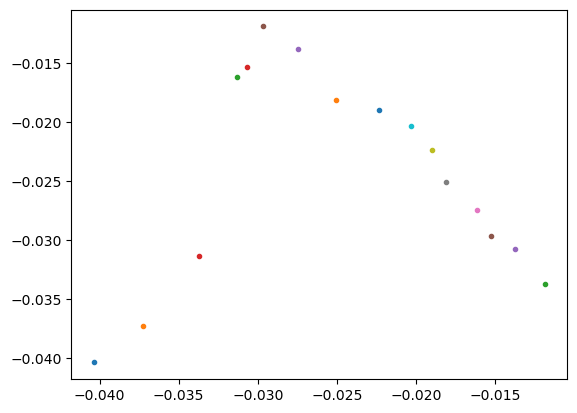

In [348]:
for e1, e2 in zip(eigvals, eigvalsx):
    plt.plot(e1,e2,'.')

In [33]:
H = HK[0]
S = batch.overlap_kspace[0]

In [75]:
%%timeit
result_einsum = torch.einsum('kn,kin,kjn->kij', occ, C, C.conj())

132 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [76]:
%%timeit
result_optimized = torch.matmul((occ.unsqueeze(1) * C), C.conj().permute(0, 2, 1))

128 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [295]:
import torch
import time

# Define dimensions
k, i, j, n = 125, 500,500,500  # Example dimensions
occ = torch.randn(n)
C = torch.randn(k, i, n)

# Using torch.einsum
start_time = time.time()
# result_einsum = torch.einsum('kn,kin,kjn->kij', occ, C, C.conj())
result_einsum = torch.einsum('n,kin,kjn->ijk', occ, C, C.conj())
einsum_time = time.time() - start_time

# Optimized approach
start_time = time.time()
# result_optimized = torch.matmul((occ.unsqueeze(1) * C), C.conj().permute(0, 2, 1))
result_optimized = torch.matmul(C.permute(2, 1, 0), (occ[:, None, None] * C.conj().permute(2, 0, 1))).permute(1, 2, 0)
optimized_time = time.time() - start_time

# Verify results and times
print("Are the results close? ", torch.allclose(result_einsum, result_optimized, atol=1e-6))
print(f"Time taken with torch.einsum: {einsum_time:.6f} seconds")
print(f"Time taken with optimized approach: {optimized_time:.6f} seconds")


RuntimeError: The size of tensor a (125) must match the size of tensor b (500) at non-singleton dimension 2

In [48]:
padded_H = xitorch.LinearOperator.m(torch.nn.functional.pad(H, (0, 4, 0, 4), "constant", 0))
N = 20
n = 16
ide = torch.eye(N)
padded_tensor = torch.zeros(H.shape[:-2] + (N, N), dtype = torch.complex128)
padded_tensor[..., :n, :n] = S
padded_tensor[..., n:N, n:N] = ide[n:N, n:N]
padded_S = xitorch.LinearOperator.m(padded_tensor)
a=symeig(xitorch.LinearOperator.m(H), M=xitorch.LinearOperator.m(S))
b=symeig(padded_H, M=padded_S)

In [55]:
~x.isclose(torch.tensor(0.))

tensor([ True,  True,  True,  True, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

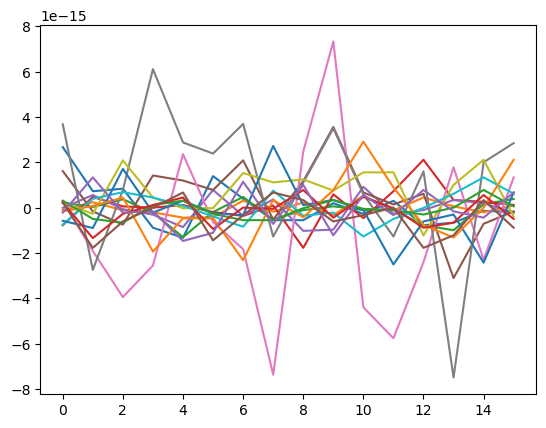

In [65]:
plt.plot(b[1][0][:16, ~x.isclose(torch.tensor(0.0))].real - a[1][0][:].real)
# plt.plot(a[1][0][:].real)

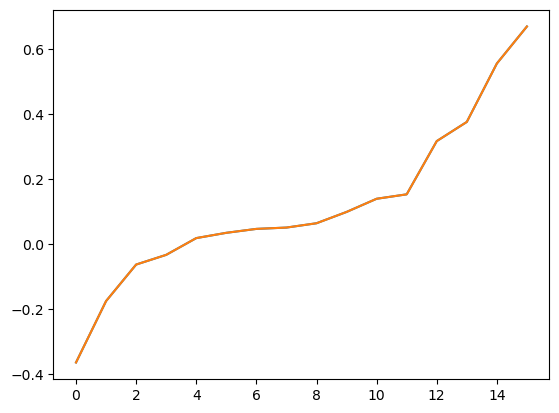

In [54]:
x = a[0][0]
plt.plot(x[~x.isclose(torch.tensor(0.))])
x = b[0][0]
plt.plot(x[~x.isclose(torch.tensor(0.))])

In [44]:
b[0][0]

tensor([-0.0993, -0.0913, -0.0672, -0.0639,  0.0157,  0.0253,  0.0593,  0.0605,
         0.0796,  0.0893,  0.0950,  0.1002,  0.1190,  0.1280,  0.1371,  0.1449])

In [25]:
%%timeit
symeig(xitorch.LinearOperator.m(torch.stack(HK)))

3.36 ms ± 25.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%%timeit
for H in HK[0]:
    symeig(xitorch.LinearOperator.m(H))

15.3 ms ± 62.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
batch = next(iter(dl))
pred = model.forward(batch.features, mldata.model_metadata)
HT = blocks_to_matrix(pred, qmdata, detach = True, structure_ids=batch.sample_id)
HK = qmdata.bloch_sum(HT, structure_ids=batch.sample_id)

pred_eigvals = []
pred_ard = []
for ifr, hk, sk in zip(batch.sample_id, HK, batch.overlap_kspace):
    ard, eig = compute_ard(hk, sk, qmdata.structures[ifr], qmdata.basis)
    pred_ard.append(ard)
    pred_eigvals.append(eig)

4


In [18]:
import torch

# Example tensor P
P = torch.randn(100, 100)  # Example tensor, adjust as needed
split_idx = [25,50,25]  # Example split index, adjust as needed

# First, split tensor P along dimension 0 and 1
slices = torch.split(P, split_idx, dim=0)
blocks = [torch.split(slice_, split_idx, dim=1) for slice_ in slices]

# Flatten the list of lists
blocks_flat = [block for sublist in blocks for block in sublist]

# Determine the maximum size of the blocks to create NxN tensors
max_dim = max([block.shape[0] for block in blocks_flat] + [block.shape[1] for block in blocks_flat])
print(max_dim)

# Pad each block to be NxN
squared_blocks = []
for block in blocks_flat:
    pad_size = (0, max_dim - block.size(1), 0, max_dim - block.size(0))  # (pad_right, pad_left, pad_bottom, pad_top)
    squared_block = torch.nn.functional.pad(block, pad_size, "constant", 0)
    squared_blocks.append(squared_block)

# Stack all squared blocks
stacked_blocks = torch.stack(squared_blocks)

# Compute the norm for each squared block along the correct axes
# Example: Compute the norm along the first dimension for each block in the stack
norms = stacked_blocks.norm(dim=1)

print(norms)


50
tensor([[5.0669, 5.0840, 5.0984, 4.6183, 5.8959, 4.0275, 4.5295, 5.3198, 4.8648,
         5.6759, 4.3142, 5.1635, 4.7012, 5.2994, 4.8145, 5.3408, 4.5333, 5.1474,
         4.7877, 6.3704, 4.4872, 5.4411, 5.2981, 5.1331, 4.5185, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [5.4193, 4.9630, 4.3443, 5.0788, 5.2226, 5.6729, 6.0060, 5.0155, 5.4075,
         4.4575, 4.7199, 5.4476, 5.7015, 5.4005, 5.3028, 3.7539, 4.6535, 4.4055,
         4.4005, 5.3336, 4.9806, 3.7950, 4.7740, 4.0894, 6.4416, 5.0568, 3.7296,
         4.9240, 5.2378, 3.8556, 4.2981, 5.4593, 4.6536, 6.5636, 5.3485, 5.4439,
         5.5033, 5.3027, 6.5082, 4.9334, 4.0275, 5.0124, 4.4845, 4.4275, 5.2035,
         4.8450, 5.1038, 5.9783, 5.1897, 4.5480],
        [5.7694, 4.3219, 4.3303, 3.8645, 5.0254, 5.1316, 5.2361, 6.1110, 5.1705,
      

# Density matrix

In [501]:
def fermidirac(E, beta, mu):
    s = len(E.shape)
    dtype = E.dtype
    if s == 0 or s == 1:
        return 1/(torch.exp(beta*(E-mu)) + 1)
    elif s == 2:
        Id = torch.eye(E.shape[0])
        return torch.linalg.inv(torch.matrix_exp(beta*(E - mu*Id)) + Id)

In [479]:
H = qmdata.fock_kspace[0][0]
S = qmdata.overlap_kspace[0][0]

E, C = symeig(xitorch.LinearOperator.m(H), M=xitorch.LinearOperator.m(S))
E = torch.diag(E)

Ef = torch.diag(E)[11].real + 1e-5*torch.diag(E).diff().mean()
beta = 2000

f = fermidirac(torch.diag(E), Ef, beta) #torch.tensor([2 if i <= 11 else 0 for i in range(H.shape[0])], dtype = torch.complex128)
# assert sum(fermidirac(torch.diag(E), Ef, beta)) == 6*frames[0].get_global_number_of_atoms(), sum(fermidirac(torch.diag(E), Ef, beta))

rho = torch.einsum('in,kn,n->ik', C, C, f)
assert torch.allclose(rho.imag, torch.zeros_like(rho.imag))
rho = rho.real

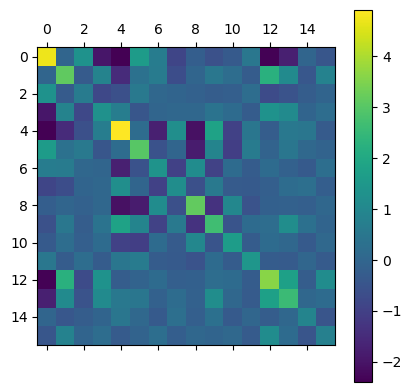

In [480]:
plt.matshow(rho)
plt.colorbar()


In [481]:
from scipy.linalg import sqrtm
sqrtSinv = torch.from_numpy(np.linalg.inv(np.complex128(sqrtm(S.numpy()))))
sqrtS = torch.from_numpy(np.complex128(sqrtm(S.numpy())))
oH = sqrtSinv@H@sqrtSinv

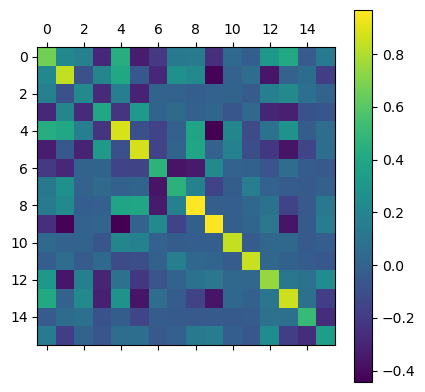

In [482]:
rho2 = sqrtS@fermidirac(oH, Ef, beta)@sqrtS
plt.matshow(rho2.real)
plt.colorbar()

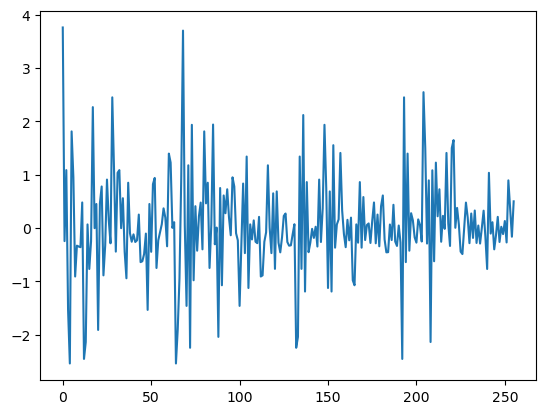

In [478]:
plt.plot((rho-rho2).real.flatten())

In [435]:
from scipy.special import factorial

In [488]:
beta = 20
nmax = 100

In [489]:
m = beta*(H-Ef*torch.eye(H.shape[0]))
# (torch.matrix_exp(m) - sum(torch.matrix_power(m, n)/factorial(n) for n in range(nmax))).norm()

In [493]:
betas = np.linspace(1,10000)
v = [torch.matrix_exp(beta*(H-Ef*torch.eye(H.shape[0]))).norm() for beta in betas]

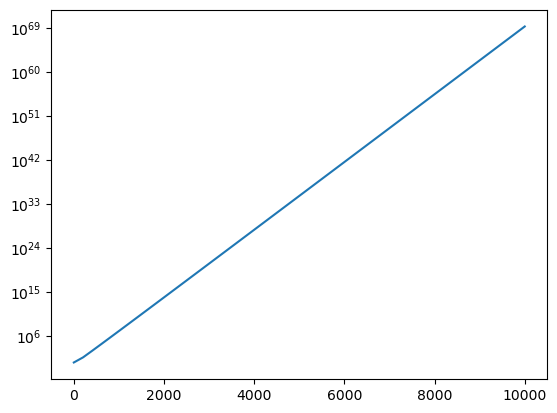

In [495]:
plt.plot(betas, v)
plt.yscale('log')

In [520]:
import torch

# Example Hamiltonian matrix (Hermitian matrix)
H = torch.tensor([
    [1.0, 0.1, 0.0],
    [0.1, 2.0, 0.1],
    [0.0, 0.1, 3.0]
], dtype=torch.float64)

# Parameters
beta = 1.0  # inverse temperature
mu = 1.5    # chemical potential

# Compute the density matrix using the Fermi-Dirac distribution
def compute_density_matrix(H, beta, mu):
    exp_matrix = torch.linalg.matrix_exp(beta * (H - mu * torch.eye(H.size(0), dtype=H.dtype)))
    rho = torch.inverse(exp_matrix + torch.eye(H.size(0), dtype=H.dtype))
    return rho

# Calculate the density matrix directly
rho_direct = fermidirac(H, beta, mu)
# rho_direct = compute_density_matrix(H, beta, mu)

# Diagonalize the Hamiltonian
eigenvalues, eigenvectors = torch.linalg.eigh(H)

# Compute the density matrix in the eigenbasis
fermi_dirac_eigenvalues = 1 / (torch.exp(beta * (eigenvalues - mu)) + 1)
rho_eigenbasis = torch.diag(fermi_dirac_eigenvalues)

# Transform rho back to the original basis
rho_explicit = eigenvectors @ rho_eigenbasis @ eigenvectors.T

# Check if both density matrices are equal
print("Directly Computed Density Matrix (rho):")
print(rho_direct)

print("\nDensity Matrix from Diagonalization (rho_explicit):")
print(rho_explicit)

# Check the difference
difference = torch.norm(rho_direct - rho_explicit)
print(f"\nDifference between the two methods: {difference.item()}")


Directly Computed Density Matrix (rho):
tensor([[ 6.2236e-01, -2.4457e-02,  2.4833e-04],
        [-2.4457e-02,  3.7804e-01, -1.9490e-02],
        [ 2.4833e-04, -1.9490e-02,  1.8288e-01]])

Density Matrix from Diagonalization (rho_explicit):
tensor([[ 6.2236e-01, -2.4457e-02,  2.4833e-04],
        [-2.4457e-02,  3.7804e-01, -1.9490e-02],
        [ 2.4833e-04, -1.9490e-02,  1.8288e-01]])

Difference between the two methods: 1.4256002198713556e-16


In [504]:
%%timeit
rho_direct = fermidirac(H, beta, mu)

194 µs ± 5.86 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [505]:
%%timeit
rho_direct = compute_density_matrix(H, beta, mu)

206 µs ± 206 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [517]:
def compute_rho_explicit(H, beta, mu):
    # Diagonalize the Hamiltonian
    eigenvalues, eigenvectors = torch.linalg.eigh(H)
    
    # Compute the density matrix in the eigenbasis
    fermi_dirac_eigenvalues = 1 / (torch.exp(beta * (eigenvalues - mu)) + 1)
    rho_eigenbasis = torch.diag(fermi_dirac_eigenvalues)
    
    # Transform rho back to the original basis
    return eigenvectors @ rho_eigenbasis @ eigenvectors.T

In [524]:
import torch

def pade_approximation(A, m):
    """ Compute the Padé approximation to the matrix exponential of A. """
    identity = torch.eye(A.size(0), dtype=A.dtype, device=A.device)
    A2 = A @ A
    A4 = A2 @ A2
    A6 = A4 @ A2
    
    U = A @ (identity + A2 * (12.0 + A4))
    V = identity + A2 * (6.0 + A4 * (60.0 + A6))
    
    return torch.linalg.solve(V - U, V + U)

def scaling_and_squaring(A, beta):
    """ Compute the matrix exponential exp(beta * A) using scaling and squaring. """
    n = torch.max(torch.zeros(1, dtype=torch.int32), torch.ceil(torch.log2(torch.linalg.norm(beta * A, ord=float('inf')))))
    n = int(n.item())  # Convert to Python scalar
    n = 50
    A_scaled = beta * A / (2**n)
    
    exp_A_scaled = pade_approximation(A_scaled, m=6)  # Use Padé approximation with m=6
    
    exp_A = exp_A_scaled
    for _ in range(n):
        exp_A = exp_A @ exp_A
    
    return exp_A

# Example Hamiltonian matrix (Hermitian matrix)
H = torch.tensor([
    [1.0, 0.1, 0.0],
    [0.1, 2.0, 0.1],
    [0.0, 0.1, 3.0]
], dtype=torch.float64)

# Parameters
beta = 1.0  # inverse temperature (large value for low T regime)
mu = 1.5      # chemical potential

# Function to compute the density matrix using scaling and squaring
def compute_density_matrix_stable(H, beta, mu):
    # Identity matrix
    I = torch.eye(H.size(0), dtype=H.dtype, device=H.device)
    
    # Shifted Hamiltonian
    H_shifted = H - mu * I
    
    # Compute the matrix exponential using scaling and squaring
    exp_neg_H_shifted = scaling_and_squaring(H_shifted, -beta)
    
    # Compute the density matrix using the stable formula
    rho = torch.inverse(I + exp_neg_H_shifted)
    
    return rho

# Calculate the density matrix using the stable method
rho = compute_density_matrix_stable(H, beta, mu)

print("Density Matrix (rho):")
print(rho)
print()
print(compute_rho_explicit(H, beta, mu))

Density Matrix (rho):
tensor([[ 0.2696,  0.0460, -0.0012],
        [ 0.0460,  0.7287,  0.0221],
        [-0.0012,  0.0221,  0.9513]])

tensor([[ 6.2236e-01, -2.4457e-02,  2.4833e-04],
        [-2.4457e-02,  3.7804e-01, -1.9490e-02],
        [ 2.4833e-04, -1.9490e-02,  1.8288e-01]])


In [699]:
orbs_mult = {
        species: 
            {tuple(k): v
            for k, v in zip(
                *np.unique(
                    np.asarray(qmdata.basis[species])[:, :2],
                    axis=0,
                    return_counts=True,
                )
            )
        }
        for species in qmdata.basis
    }

In [707]:
ai=aj=14
orbs_i = orbs_mult[ai]
orbs_j = orbs_mult[aj]
shapes = {(k1 + k2): (orbs_i[tuple(k1)], orbs_j[tuple(k2)]) for k1 in orbs_i for k2 in orbs_j}

In [701]:
from mlelec.utils._utils import _orbs_offsets, _atom_blocks_idx
dataset = qmdata
orbs_tot, orbs_offset = _orbs_offsets(dataset.basis)
atom_blocks_idx = _atom_blocks_idx(dataset.structures, orbs_tot)

In [750]:
A,i,j=0,0,1
ai=aj=14
ni,li=3,0
nj,lj=3,1

In [751]:
pos_ij = atom_blocks_idx[A,i,j]
offsets = orbs_offset[(ai, ni, li)], orbs_offset[(aj, nj, lj)]
dim = shapes[ni,li,nj,lj]

In [835]:
nTs = [len(qmdata.fock_realspace[A]) for A in range(len(qmdata))]
reconstructed_matrices = [torch.zeros((nT, nao, nao), dtype = torch.float64, device = device) for nT, nao in zip(nTs, qmdata.nao)]

In [836]:
T_dict = [{T: i for i, T in enumerate(H)} for H in qmdata.fock_realspace]

In [1011]:
H_mask = {}
B_mask = {}
slices = {}
factors = {}

ISQRT_2 = 1/np.sqrt(2)
sort_orbs = True
all_pairs = False

for k, b in unc_blocks.items():
    kl = block_type, ai, ni, li, aj, nj, lj = tuple(k.values.tolist())
    
    bt1_factor = ISQRT_2 / (1 if (sort_orbs and ai == aj and ni == nj and li == lj) else 2) / (2 if all_pairs else 1)

    orbs_i = orbs_mult[ai]
    orbs_j = orbs_mult[aj]
    
    shapes = {(k1 + k2): (orbs_i[tuple(k1)], orbs_j[tuple(k2)]) for k1 in orbs_i for k2 in orbs_j}
    offsets = orbs_offset[(ai, ni, li)], orbs_offset[(aj, nj, lj)]
    dim = shapes[ni,li,nj,lj]

    H_mask[kl] = {A: torch.zeros_like(H, dtype = torch.bool) for A, H in enumerate(reconstructed_matrices)}
    B_mask[kl] = {A: torch.zeros_like(b.values, dtype = torch.bool) for A in range(len(reconstructed_matrices))}
    slices[kl] = {}
    factors[kl] = {}
    
    for i, ((A,i,j,Tx,Ty,Tz), val) in enumerate(zip(b.samples.values.tolist(), b.values)):

        offsite_perm_fac = (0.5 if (i == j and Tx != 0 and Ty != 0 and Tz != 0 and not all_pairs) else 1)

        bp, bm = _get_fac(block_type, sort_orbs, ni, nj, li, lj, offsite_perm_fac, bt1_factor)
            
        iT = T_dict[A][Tx,Ty,Tz]
        
        pos_ij = atom_blocks_idx[A,i,j]
        slices_ = [slice(s+o, s+o+e) for s, (o,e) in itertools.product(pos_ij, zip(offsets, dim))]
        slices_ = list(itertools.product(slices_[:2], slices_[2:]))
        for s in slices_:
            H_mask[kl][A][iT][s] = True

        B_mask[kl][A][i] = True

        if (A, iT) not in slices[kl]:
            slices[kl][A,iT] = []
            factors[kl][A,iT] = []
        # for s in slices_:
        slices[kl][A, iT].extend(slices_)
        #     factors[kl][A, iT].append((bp, bm))
        
        # for s in slices_:
        #     reconstructed_matrices[A][iT, s].add_(val*f)

In [1026]:
unc_blocks

TensorMap with 8 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j
          -1         14       3    1      14       3    1
          -1         14       3    0      14       3    1
          0          14       3    0      14       3    0
          0          14       3    1      14       3    1
          0          14       3    0      14       3    1
          1          14       3    0      14       3    0
          1          14       3    1      14       3    1
          1          14       3    0      14       3    1

In [1028]:
unc_blocks[0].values[B_mask[(-1,
  14,
  3,
  1,
  14,
  3,
  1)][0]].shape

torch.Size([27])

In [1043]:
import torch

def get_subblocks(tensor, indices):
    # Convert indices to tensor
    indices_tensor = torch.tensor(indices, dtype=torch.long)
    
    # Create a range tensor
    range_tensor = torch.arange(tensor.size(0), device=tensor.device).unsqueeze(0)
    
    # Create a mask for the desired subblocks
    mask = (range_tensor >= indices_tensor[:, 0].unsqueeze(1)) & (range_tensor < indices_tensor[:, 1].unsqueeze(1))
    
    # Use the mask to select the subblocks
    selected_subblocks = tensor[mask]
    
    return selected_subblocks

# Example usage
tensor = torch.arange(20)
indices = [[2, 5], [8, 12], [15, 18]]

result = get_subblocks(tensor, indices)
print(result)

IndexError: too many indices for tensor of dimension 1

In [1042]:
a[0:3,0:3]

array([[-0.0851156 , -0.56430103,  0.96676801],
       [ 0.20727075,  0.30773257,  0.15925047],
       [-0.25595767, -0.34804638, -0.78236697]])

In [1033]:
H_mask[(-1,14,3,1,14,3,1)][0].shape

torch.Size([63, 16, 16])

In [1034]:
A = 0
reconstructed_matrices[A][H_mask[(-1,14,3,1,14,3,1)][A]].shape

torch.Size([81])

In [ ]:
unc_blocks[0].samples.values[3:]

In [1016]:
reconstructed_matrices[0][0][slices[(-1,
  14,
  3,
  1,
  14,
  3,
  1)][0,0][0]]

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [1002]:
reconstructed_matrices[0][0][slices[(-1,
  14,
  3,
  1,
  14,
  3,
  1)][0,0]]

IndexError: too many indices for tensor of dimension 2

In [996]:
reconstructed_matrices[0][0:3,3:4,3:6].shape

torch.Size([3, 1, 3])

In [976]:
for k, b in unc_blocks.items():
    kl = block_type, ai, ni, li, aj, nj, lj = tuple(k.values.tolist())
    
    for A,iT in slices[kl]:
        slices_ = slices[kl][A,iT]
        for s, bp, bm in zip(slices_, factors[kl][A,iT]):
            reconstructed_matrices[A][iT] += 

{(-1,
  14,
  3,
  1,
  14,
  3,
  1): {(0, 0): [slice(1, 4, None),
   slice(1, 4, None),
   slice(5, 8, None),
   slice(5, 8, None),
   slice(1, 4, None),
   slice(1, 4, None),
   slice(9, 12, None),
   slice(9, 12, None),
   slice(1, 4, None),
   slice(1, 4, None),
   slice(13, 16, None),
   slice(13, 16, None),
   slice(5, 8, None),
   slice(5, 8, None),
   slice(9, 12, None),
   slice(9, 12, None),
   slice(5, 8, None),
   slice(5, 8, None),
   slice(13, 16, None),
   slice(13, 16, None),
   slice(9, 12, None),
   slice(9, 12, None),
   slice(13, 16, None),
   slice(13, 16, None)], (0, 3): [slice(1, 4, None),
   slice(1, 4, None),
   slice(9, 12, None),
   slice(9, 12, None)], (0, 4): [slice(5, 8, None),
   slice(5, 8, None),
   slice(13, 16, None),
   slice(13, 16, None),
   slice(9, 12, None),
   slice(9, 12, None),
   slice(13, 16, None),
   slice(13, 16, None)]},
 (-1,
  14,
  3,
  0,
  14,
  3,
  1): {(0, 0): [slice(0, 1, None),
   slice(1, 4, None),
   slice(4, 5, None),
   s

In [972]:
def _get_fac(block_type, sort_orbs, ni, nj, li, lj, offsite_perm_fac, bt1_factor):
    if block_type == 0:
        bp = 0.5 if not sort_orbs else (1 if not (ni == nj and li == lj) else 0.5)
        bm = bp * offsite_perm_fac
    elif block_type == 2:
        bp = 0.5 if not all_pairs else 1
        bm = bp * offsite_perm_fac
    else:
        bp = bt1_factor * offsite_perm_fac 
        bm = -bt1_factor * offsite_perm_fac 
    return bp, bm

In [969]:
k = next(iter(H_mask))
print(reconstructed_matrices[0][H_mask[k][0]].shape)
print(unc_blocks[0].values[B_mask[k][0]].shape)

torch.Size([432])
torch.Size([27])


In [970]:
432/27

16.0

In [933]:
block_type, ai, ni, li, aj, nj, lj = -1, 14, 3, 0, 14, 3, 1

orbs_i = orbs_mult[ai]
orbs_j = orbs_mult[aj]

shapes = {(k1 + k2): (orbs_i[tuple(k1)], orbs_j[tuple(k2)]) for k1 in orbs_i for k2 in orbs_j}
offsets = orbs_offset[(ai, ni, li)], orbs_offset[(aj, nj, lj)]
dim = shapes[ni,li,nj,lj]

A,i,j,Tx,Ty,Tz=0,0,1,0,0,0
iT = T_dict[A][Tx,Ty,Tz]

pos_ij = atom_blocks_idx[A,i,j]
p = [slice(p+o, p+o+d) for p, o, d in zip(pos_ij, offsets, dim)]

In [934]:
# start = ['i_start', 'j_start']
# end = ['phi_end', 'psi_end']
# off = ['phi_offset', 'psi_offset']
# start = ['i ', 'j ']
# end = ['ae ', 'be ']
# off = ['ao ', 'bo ']
start = pos_ij
end = dim
offset = offsets

import itertools

In [935]:
all = [slice(s+o, s+o+e) for s, (o,e) in itertools.product(start, zip(offset, end))]
list(itertools.product(all[:2], all[2:]))

[(slice(0, 1, None), slice(4, 5, None)),
 (slice(0, 1, None), slice(5, 8, None)),
 (slice(1, 4, None), slice(4, 5, None)),
 (slice(1, 4, None), slice(5, 8, None))]

In [914]:
first = [((s,o), (s,o,e)) for s, (o,e) in itertools.product(start, zip(off, end))]

In [900]:
[((s1 + o1, s1 + o1 + e1), (s2 + o2, s2 + o2 + e2)) for (s1,o1,e1), (s2,o2,e2) in itertools.product(itertools.product(start, off, end), repeat = 2)]

[(('i ao ', 'i ao ae '), ('i ao ', 'i ao ae ')),
 (('i ao ', 'i ao ae '), ('i ao ', 'i ao be ')),
 (('i ao ', 'i ao ae '), ('i bo ', 'i bo ae ')),
 (('i ao ', 'i ao ae '), ('i bo ', 'i bo be ')),
 (('i ao ', 'i ao ae '), ('j ao ', 'j ao ae ')),
 (('i ao ', 'i ao ae '), ('j ao ', 'j ao be ')),
 (('i ao ', 'i ao ae '), ('j bo ', 'j bo ae ')),
 (('i ao ', 'i ao ae '), ('j bo ', 'j bo be ')),
 (('i ao ', 'i ao be '), ('i ao ', 'i ao ae ')),
 (('i ao ', 'i ao be '), ('i ao ', 'i ao be ')),
 (('i ao ', 'i ao be '), ('i bo ', 'i bo ae ')),
 (('i ao ', 'i ao be '), ('i bo ', 'i bo be ')),
 (('i ao ', 'i ao be '), ('j ao ', 'j ao ae ')),
 (('i ao ', 'i ao be '), ('j ao ', 'j ao be ')),
 (('i ao ', 'i ao be '), ('j bo ', 'j bo ae ')),
 (('i ao ', 'i ao be '), ('j bo ', 'j bo be ')),
 (('i bo ', 'i bo ae '), ('i ao ', 'i ao ae ')),
 (('i bo ', 'i bo ae '), ('i ao ', 'i ao be ')),
 (('i bo ', 'i bo ae '), ('i bo ', 'i bo ae ')),
 (('i bo ', 'i bo ae '), ('i bo ', 'i bo be ')),
 (('i bo ', 'i bo ae

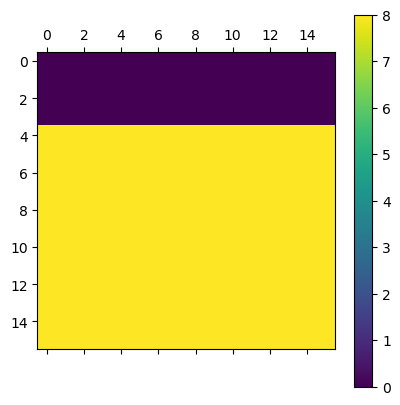

In [949]:
plt.matshow(sum(mask[kl][0][4] for k in mask))
plt.colorbar()

In [867]:
iphi_jpsi_slice = (slice(i_start + phioffset, i_start + phioffset + phi_end),
                   slice(j_start + psioffset, j_start + psioffset + psi_end))
ipsi_jphi_slice = (slice(i_start + psioffset, i_start + psioffset + psi_end),
                   slice(j_start + phioffset, j_start + phioffset + phi_end))
jphi_ipsi_slice = (slice(j_start + phioffset, j_start + phioffset + phi_end),
                   slice(i_start + psioffset, i_start + psioffset + psi_end))
jpsi_iphi_slice = (slice(j_start + psioffset, j_start + psioffset + psi_end),
                   slice(i_start + phioffset, i_start + phioffset + phi_end))

TensorBlock
    samples (9): ['structure', 'center', 'neighbor', 'cell_shift_a', 'cell_shift_b', 'cell_shift_c']
    components (3, 3): ['m_i', 'm_j']
    properties (1): ['dummy']
    gradients: None

In [853]:
reconstructed_matrices[0][mask[next(iter(mask))][0]].shape

torch.Size([864])

In [838]:
reconstructed_matrices[0][mask[next(iter(mask))][0]] += torch.ones(864)

In [839]:
reconstructed_matrices[0][1]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1

In [772]:
p = [slice(p+o, p+o+d) for p, o, d in zip(pos_ij, offsets, dim)]
print(p)

[slice(0, 1, None), slice(5, 8, None)]


In [766]:
mat = torch.zeros(16,16)

In [779]:
torch.unique(unc_blocks[0].samples.values[:, 3:], dim=0)

tensor([[-1,  0,  0],
        [-1,  1,  0],
        [ 0, -1,  0],
        [ 0,  0, -1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, -1],
        [ 0,  1,  0],
        [ 1, -1,  0],
        [ 1,  0,  0],
        [ 1,  1,  0]], dtype=torch.int32)

In [758]:
0:1,5:8

SyntaxError: illegal target for annotation (1109963675.py, line 1)

In [735]:
offsets

(0, 1)

In [716]:
psioffset

1